In [104]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import numpy as np
import lightgbm as lgb
from matplotlib.lines import Line2D
from src.best_params import cargar_mejores_hiperparametros
from src.final_training import entrenar_modelo_final_pesos
from src.loader import convertir_clase_ternaria_a_target_peso
from src.gain_function import lgb_gan_eval
from src.grafico_test import crear_grafico_ganancia_avanzado_multi, crear_grafico_ganancia_envios, crear_grafico_ganancia_avanzado

In [3]:
STUDY_NAME = "lgb_optimization_cv_competencia01_l"
SEMILLA= [839071, 666557, 390653, 408341, 858577, 156893, 220481, 557412, 111058, 401171]
MES_TRAIN= ["202101", "202102"]
MES_VALIDACION= "202103"
MES_TEST= "202104"

In [4]:
# cargar el archivo JSON con los mejores hiperparámetros

best_params = cargar_mejores_hiperparametros(STUDY_NAME)

print("Mejores Hiperparámetros Optuna:")
print(best_params)

# Cargar datos para entrenar los modelos y evaluar ganancia en test

fe_path = f"data/df_fe_{STUDY_NAME}.csv"

if os.path.exists(fe_path):
    print(f"Archivo de features encontrado: {fe_path}. Cargando desde disco.")
    df = pd.read_csv(fe_path)
else: 
    raise FileNotFoundError(f"Archivo de features no encontrado: {fe_path}")


Mejores Hiperparámetros Optuna:
{'num_iterations': 844, 'num_leaves': 272, 'learning_rate': 0.10013019702598346, 'feature_fraction': 0.5859297600103615, 'bagging_fraction': 1.0, 'min_child_samples': 29, 'max_depth': 10, 'reg_lambda': 1.634368536567913, 'reg_alpha': 2.591381940083626, 'min_gain_to_split': 4.10868687763755, 'scale_pos_weight': 97, 'pos_bagging_fraction': 1.0, 'neg_bagging_fraction': 0.01, 'bagging_freq': 1, 'objective': 'binary', 'metric': 'None', 'random_state': 839071}
Archivo de features encontrado: data/df_fe_lgb_optimization_cv_competencia01_l.csv. Cargando desde disco.


In [5]:
#df.groupby(['foto_mes'])['clase_ternaria'].value_counts(dropna=False)

In [6]:
# Convertir la clase ternaria a target + peso

df = convertir_clase_ternaria_a_target_peso(df)

In [7]:
# Preparar datos de entrenamiento (TRAIN + VALIDACION) y test

if isinstance(MES_TRAIN, list):
   periodos_entrenamiento = MES_TRAIN + [MES_VALIDACION]
else:
   periodos_entrenamiento = [MES_TRAIN, MES_VALIDACION]
  
df_train_completo = df[df['foto_mes'].astype(str).isin(periodos_entrenamiento)]
df_test = df[df['foto_mes'].astype(str) == MES_TEST]

In [8]:
df_train_completo.groupby(['foto_mes'])[['clase_ternaria','clase_peso']].value_counts(dropna=False)

foto_mes  clase_ternaria  clase_peso
202101    0.0             1.00000       160083
          1.0             1.00002          825
                          1.00001          619
202102    0.0             1.00000       160292
          1.0             1.00002         1032
                          1.00001          831
202103    0.0             1.00000       161121
          1.0             1.00001         1037
                          1.00002          951
Name: count, dtype: int64

In [9]:

X= df_train_completo.copy() 
X = X.drop(columns=['clase_ternaria', 'clase_peso'])
y= df_train_completo['clase_ternaria'].values
weights= df_train_completo['clase_peso'].values  

X_test = df_test.copy()
X_test = X_test.drop(columns=['clase_ternaria', 'clase_peso'])
y_test = df_test['clase_peso'].values
y_test = np.where(y_test == 1.00002, 1, 0)  # Convertir pesos de clase_ternaria a 1.00002 y 1

In [10]:
train_data = lgb.Dataset(X, label=y, weight=weights)
 

In [ ]:
# #eliminar la clave learn_rate de best_params si existe
# del best_params['learn_rate']
# 

In [14]:
best_params_seed = best_params.copy()
best_params

{'num_iterations': 844,
 'num_leaves': 272,
 'learning_rate': 0.10013019702598346,
 'feature_fraction': 0.5859297600103615,
 'bagging_fraction': 1.0,
 'min_child_samples': 29,
 'max_depth': 10,
 'reg_lambda': 1.634368536567913,
 'reg_alpha': 2.591381940083626,
 'min_gain_to_split': 4.10868687763755,
 'scale_pos_weight': 97,
 'pos_bagging_fraction': 1.0,
 'neg_bagging_fraction': 0.01,
 'bagging_freq': 1,
 'objective': 'binary',
 'metric': 'None',
 'random_state': 839071}

In [ ]:
## Entreanar modelos con distintas semillas y guardar predicciones
os.makedirs("resultados_test", exist_ok=True)
predicciones_test_list = []

for seed in SEMILLA:
    

    best_params_seed['seed'] = seed  # Asegurarse de que la semilla está en los parámetros
    params = {
    'objective': 'binary',
    'metric': 'None',  # Usamos nuestra métrica personalizada
    #    'random_state': SEMILLA[0] if isinstance(SEMILLA, list) else SEMILLA,
    #'verbose': -1,
    **best_params_seed  # Agregar los mejores hiperparámetros
    }

     
    # Entrenar modelo con la semilla actual
    model = lgb.train(
        best_params_seed,
        train_data,
        valid_sets=None,
        feval=lgb_gan_eval
    )

    # Predecir en test
    y_pred_proba = model.predict(X_test)

    predicciones_test = pd.DataFrame({
        'probabilidad': y_pred_proba,
        'clase_ternaria': y_test
    })
    predicciones_test_list.append(predicciones_test)

    predicciones_test.to_csv(f"resultados_test/Modelo_{STUDY_NAME}_predicciones_test_semilla_{seed}.csv", index=False)

[LightGBM] [Warning] seed is set=839071, random_state=839071 will be ignored. Current value: seed=839071
[LightGBM] [Warning] seed is set=839071, random_state=839071 will be ignored. Current value: seed=839071
[LightGBM] [Info] Number of positive: 5295, number of negative: 481496
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.697087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 93962
[LightGBM] [Info] Number of data points in the train set: 486791, number of used features: 724
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.010878 -> initscore=-4.510120
[LightGBM] [Info] Start training from score -4.510120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [36]:
# sumar las probabilidades de cada predicciones_test en predicciones_test_list
predicciones_test_final = sum(df['probabilidad'] for df in predicciones_test_list) / len(predicciones_test_list)

In [ ]:
predic_list = []
for df in predicciones_test_list:
    predic_list.append(np.array(df['probabilidad']))

In [37]:
predicciones_test_final

0         0.081580
1         0.005090
2         0.203203
3         0.031805
4         0.887386
            ...   
163413    0.329474
163414    0.000305
163415    0.001358
163416    0.975009
163417    0.000772
Name: probabilidad, Length: 163418, dtype: float64

In [40]:
predicciones_test_final = pd.DataFrame({
        'probabilidad': sum(df['probabilidad'] for df in predicciones_test_list) / len(predicciones_test_list),
        'clase_ternaria': y_test
    })

In [ ]:
predicciones_test_final.sort_values('probabilidad', ascending=False, inplace=True)

     seed  indice_maximo  ganancia_maxima
3  408341          10274        372900000
0  839071           8812        368540000
6  220481           8915        368080000
9  401171          10893        363720000
8  111058           8482        363140000
5  156893          11600        362380000
1  666557          13055        361280000
7  557412          12416        358060000
4  858577           9217        356440000
2  390653           9588        353820000


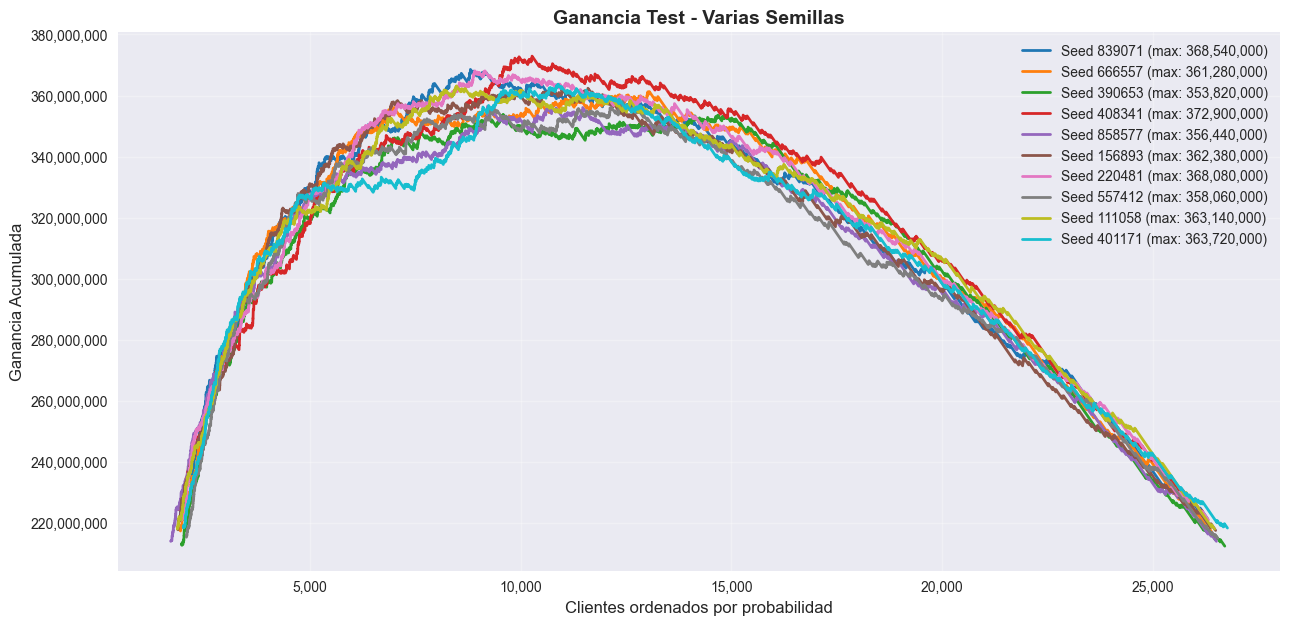

In [84]:
# Graficar las ganancias en test para las distintas semillas
from src.grafico_test import crear_grafico_ganancia_avanzado_multi
import importlib
import src.grafico_test
importlib.reload(src.grafico_test)


y_pred_proba_list = []
for df in predicciones_test_list:
    y_pred_proba_list.append(df['probabilidad'].values)

resultados = crear_grafico_ganancia_avanzado_multi(y_test, y_pred_proba_list, SEMILLA, titulo_personalizado="Ganancia Test - Varias Semillas")


In [53]:
envios = resultados['indice_maximo'].mean()
prop_envios = envios / len(predicciones_test_final)
envios, prop_envios

(np.float64(10325.2), np.float64(0.06318275832527628))

In [ ]:
# Guardo las predicciones 
predicciones_test_final.to_csv(f"resultados_test/Modelo_{STUDY_NAME}_predicciones_test_multiples_semillas.csv", index=False)

In [ ]:
y_pred_proba_prom = predicciones_test_final['probabilidad'].values
y_pred_proba_prom

In [115]:
crear_grafico_ganancia_avanzado(y_test, y_pred_proba_prom, titulo_personalizado='Ganancia por envíos para modelo entrenado con multiples semillas' )

'resultados/lgb_optimization_cv_competencia01_l_ganancia_avanzado_20251012_173057.png'

## Gráfico de Ganancia en iteraciones de Optimización Bayesiana

In [26]:
# Cargar el archivo JSON con los resultados de Optuna

df = pd.read_json(f"resultados/{STUDY_NAME}_iteraciones.json")
print(df.head())

#Graficar ganancia Optuna eje x trial_number eje y ganancia
# Configurar el estilo
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(12, 6))

# Crear el gráfico
sns.lineplot(data=df, x='trial_number', y='value', marker='o', linewidth=2, markersize=6)

# Personalizar el gráfico
plt.title(f'Evolución de la Ganancia por Iteración de Optuna \n {STUDY_NAME}', fontsize=16, fontweight='bold')
plt.xlabel('Número de Trial', fontsize=12)
plt.ylabel('Ganancia', fontsize=12)
plt.grid(True, alpha=0.3)

# Formatear el eje y para mostrar valores en millones
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

# Ajustar layout
# Mostrar estadísticas como leyenda en el gráfico
stats_max = df['value'].max()
stats_min = df['value'].min()
stats_mean = df['value'].mean()
best_trial = int(df.loc[df['value'].idxmax(), 'trial_number'])

stats_text = (
    f"Ganancia máx: {stats_max:,.0f}\n"
    f"Ganancia mín: {stats_min:,.0f}\n"
    f"Ganancia prom: {stats_mean:,.0f}\n"
    f"Trial con mejor ganancia: {best_trial}"
)

proxy = Line2D([], [], linestyle='none', label=stats_text)
#plt.show()
plt.gca().legend(handles=[proxy],
                 loc='lower right',
                 bbox_to_anchor=(1.02, 1),
                 title='Estadísticas de ganancia',
                 title_fontsize=11,
                 fontsize=10,
                 frameon=True)
plt.tight_layout()
 # Guardar gráfico con timestamp
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
os.makedirs("resultados", exist_ok=True)
ruta_archivo = f"resultados/{STUDY_NAME}_ganancia_optimización_{timestamp}.png"
plt.savefig(ruta_archivo, dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

   trial_number                                             params      value  \
0             0  {'num_iterations': 727, 'num_leaves': 1546, 'l...  151013119   
1             1  {'num_iterations': 344, 'num_leaves': 645, 'le...  163215439   
2             2  {'num_iterations': 774, 'num_leaves': 1881, 'l...  159502074   
3             3  {'num_iterations': 532, 'num_leaves': 786, 'le...  146244219   
4             4  {'num_iterations': 457, 'num_leaves': 1650, 'l...  150281612   

                    datetime  \
0 2025-10-11 09:19:32.655947   
1 2025-10-11 09:22:07.933281   
2 2025-10-11 09:25:42.880858   
3 2025-10-11 09:29:52.218468   
4 2025-10-11 09:31:28.696915   

                                        ganancias_cv     state  
0  [116636000.0, 123760000.0, 128324000.0, 128376...  COMPLETE  
1  [132288000.0, 139428000.0, 145536000.0, 148584...  COMPLETE  
2  [105384000.0, 107828000.0, 115832000.0, 122408...  COMPLETE  
3  [93380000.0, 113204000.0, 117376000.0, 1195520...  COMPLE